In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib
import altair as alt
import plotly.express as px
from sklearn.metrics import confusion_matrix

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn import ensemble
from sklearn import svm

from sklearn.model_selection import KFold, cross_validate, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection
from sklearn.metrics import classification_report

from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, mutual_info_classif, f_classif, SelectFromModel, f_regression, mutual_info_regression, RFE, RFECV

In [4]:
df = pd.read_csv('csv_files/df.csv')
df.drop(['Index'], axis = 1, inplace = True)

df_all_years = pd.read_csv('csv_files/atp_data_4.csv', sep = ";")
df_year = df_all_years['Year']

# Étude statistique des variables

Crée le dataframe qui fait référence au premier paragraphe de la section **Étude statistique des variables** 

In [5]:
df_somme = df[['1_year_pts_delta', '8_months_pts_delta',
       '4_months_pts_delta', '1_year_pts_delta_surface',
       '8_months_pts_delta_surface', '4_months_pts_delta_surface',
       'h2h_player_score_delta', 'h2h_player_score_last_5_delta',
       'h2h_player_score_surface_delta',
       'h2h_player_score_last_5_surface_delta', 'V-D_rang_delta',
       'matchs_played_3w_delta', 'V-D_3w_delta',
       'V-D_3y_delta', 'V-D_3y_format_delta', 'V-D_3y_surface_delta', 
       'V-D_Series_and_Round_5y_delta', 'V-D_tournament_5y_delta']]

df_exception = df[['days_since_last_match_played_delta']]

df_ratio = df[['ratioV_3w_delta', 'ratioV_3y_delta',
               'ratioV_3y_format_delta', 'ratioV_3y_surface_delta', 'ratioV_Series_and_Round_5y_delta',
               'ratioV_tournament_5y_delta']]

df_target = df[['target']]
df_somme = df_somme.replace(to_replace = [0, 0.0], value = [np.nan, np.nan])
df_exception = df_exception.replace(to_replace = [0, 0.0], value = [np.nan, np.nan])
df_ratio = df_ratio.replace(to_replace = [1, 1.0], value = [np.nan, np.nan])

df_somme[df_somme > 0] = 1
df_somme[df_somme < 0] = 0

df_exception[df_exception < 0] = 1
df_exception[df_exception > 0] = 0

df_ratio[df_ratio > 1] = 1
df_ratio[df_ratio < 1] = 0

df_bin = pd.concat([df_year, df_target, df_somme, df_exception, df_ratio], axis=1)


Affichage du dataframe crée

In [6]:
df_bin.sample(5)

,Year,target,1_year_pts_delta,8_months_pts_delta,4_months_pts_delta,1_year_pts_delta_surface,8_months_pts_delta_surface,4_months_pts_delta_surface,h2h_player_score_delta,h2h_player_score_last_5_delta,...,V-D_3y_surface_delta,V-D_Series_and_Round_5y_delta,V-D_tournament_5y_delta,days_since_last_match_played_delta,ratioV_3w_delta,ratioV_3y_delta,ratioV_3y_format_delta,ratioV_3y_surface_delta,ratioV_Series_and_Round_5y_delta,ratioV_tournament_5y_delta
52137,2018,1,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
57359,2021,0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,1.0,1.0,NaN,0.0,0.0,1.0,1.0,1.0,1.0,0.0
15992,2005,0,0.0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,...,1.0,0.0,NaN,NaN,0.0,0.0,0.0,1.0,0.0,NaN
7329,2002,1,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,0.0,NaN,0.0,0.0,NaN,1.0,NaN
35440,2012,0,0.0,0.0,0.0,1.0,1.0,1.0,NaN,NaN,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0


Crée 2 dataframes dont l'un représente pour chaque variable son taux de réussite par année et l'autre son taux de valeurs prédictibles par année également. 

In [8]:
good_predictions = []
liste_values_indeter = []
name_variables = []
years = np.arange(2000, 2022, 1)
df_bin = df_bin.set_index('Year')

for year in years :
    
    df_int = df_bin.loc[year, :]
    
    good_predictions_int = []
    liste_values_indeter_int = []
    
    for colonne in df_int.columns[1:] :
        
        values_indeter = 1-(df_int[colonne].isna().sum()/len(df_int))
        df_only_1_var = df_int[['target', colonne]].dropna(how='any')
        df_only_1_var['equal'] = np.where(df_only_1_var["target"] == df_only_1_var[colonne], True, False)
        efficacity = df_only_1_var['equal'].sum()/len(df_only_1_var)
        good_predictions_int.append(round(efficacity,2))
        liste_values_indeter_int.append(round(values_indeter,2))
        
    good_predictions.append(good_predictions_int)
    liste_values_indeter.append(liste_values_indeter_int)

Affichage du dataframe représentant le taux de réussite

In [9]:
df_corr = pd.DataFrame(good_predictions, index = years, columns = df_bin.columns[1:]).transpose()
df_corr

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
1_year_pts_delta,0.63,0.62,0.64,0.64,0.64,0.66,0.65,0.66,0.67,0.68,...,0.68,0.67,0.68,0.68,0.66,0.65,0.64,0.62,0.63,0.63
8_months_pts_delta,0.62,0.62,0.63,0.64,0.63,0.66,0.65,0.66,0.67,0.68,...,0.68,0.67,0.68,0.68,0.66,0.64,0.64,0.62,0.64,0.63
4_months_pts_delta,0.63,0.63,0.63,0.65,0.64,0.66,0.65,0.66,0.66,0.66,...,0.68,0.66,0.68,0.68,0.67,0.65,0.63,0.62,0.64,0.63
1_year_pts_delta_surface,0.62,0.62,0.64,0.66,0.63,0.66,0.66,0.66,0.66,0.67,...,0.67,0.67,0.67,0.67,0.66,0.65,0.63,0.63,0.64,0.62
8_months_pts_delta_surface,0.62,0.63,0.63,0.66,0.63,0.65,0.65,0.66,0.65,0.65,...,0.66,0.67,0.67,0.66,0.66,0.64,0.62,0.62,0.64,0.62
4_months_pts_delta_surface,0.62,0.64,0.63,0.65,0.64,0.64,0.64,0.66,0.65,0.64,...,0.65,0.66,0.65,0.66,0.65,0.63,0.62,0.62,0.65,0.62
h2h_player_score_delta,0.60,0.60,0.59,0.56,0.60,0.60,0.60,0.61,0.61,0.61,...,0.66,0.64,0.65,0.65,0.63,0.63,0.62,0.60,0.59,0.59
h2h_player_score_last_5_delta,0.60,0.60,0.59,0.56,0.60,0.60,0.60,0.61,0.61,0.62,...,0.66,0.63,0.65,0.65,0.63,0.62,0.61,0.59,0.59,0.59
h2h_player_score_surface_delta,0.59,0.60,0.58,0.58,0.61,0.59,0.59,0.61,0.59,0.62,...,0.65,0.64,0.66,0.64,0.62,0.63,0.62,0.60,0.62,0.58
h2h_player_score_last_5_surface_delta,0.59,0.60,0.58,0.58,0.61,0.59,0.59,0.61,0.59,0.61,...,0.65,0.64,0.66,0.64,0.62,0.63,0.61,0.59,0.62,0.58


Affichage du dataframe représentant le taux de valeurs prédictibles

In [10]:
df_indeter = pd.DataFrame(liste_values_indeter, index = years, columns = df_bin.columns[1:]).transpose()
df_indeter

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
1_year_pts_delta,0.95,1.00,1.00,1.00,1.00,1.00,0.99,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
8_months_pts_delta,0.95,0.99,1.00,0.99,1.00,1.00,0.99,1.00,0.99,0.99,...,0.99,0.99,1.00,1.00,0.99,1.00,1.00,1.00,1.00,0.99
4_months_pts_delta,0.95,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,...,0.99,0.99,0.99,1.00,0.99,0.99,0.99,0.99,0.99,0.99
1_year_pts_delta_surface,0.84,0.99,0.98,0.98,0.98,0.98,0.99,0.99,0.98,0.99,...,0.98,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.95
8_months_pts_delta_surface,0.84,0.94,0.94,0.93,0.92,0.92,0.92,0.90,0.91,0.93,...,0.93,0.94,0.94,0.95,0.95,0.95,0.94,0.95,0.98,0.95
4_months_pts_delta_surface,0.83,0.89,0.89,0.87,0.88,0.88,0.86,0.86,0.86,0.88,...,0.89,0.88,0.89,0.89,0.90,0.89,0.89,0.90,0.92,0.90
h2h_player_score_delta,0.13,0.28,0.35,0.36,0.36,0.41,0.40,0.42,0.40,0.46,...,0.47,0.47,0.48,0.49,0.44,0.46,0.44,0.42,0.39,0.37
h2h_player_score_last_5_delta,0.13,0.28,0.35,0.36,0.37,0.41,0.41,0.43,0.40,0.47,...,0.47,0.48,0.49,0.50,0.45,0.46,0.44,0.43,0.39,0.37
h2h_player_score_surface_delta,0.07,0.16,0.21,0.23,0.23,0.26,0.26,0.27,0.25,0.32,...,0.33,0.35,0.34,0.35,0.31,0.31,0.30,0.31,0.30,0.25
h2h_player_score_last_5_surface_delta,0.07,0.16,0.21,0.23,0.23,0.26,0.26,0.28,0.26,0.32,...,0.33,0.35,0.35,0.35,0.32,0.32,0.30,0.31,0.30,0.25


Afin que ces résultats soient plus parlant, nous avons décidé de les afficher à partir
d'une heat map

Affichage de la heatmap du taux de réussite

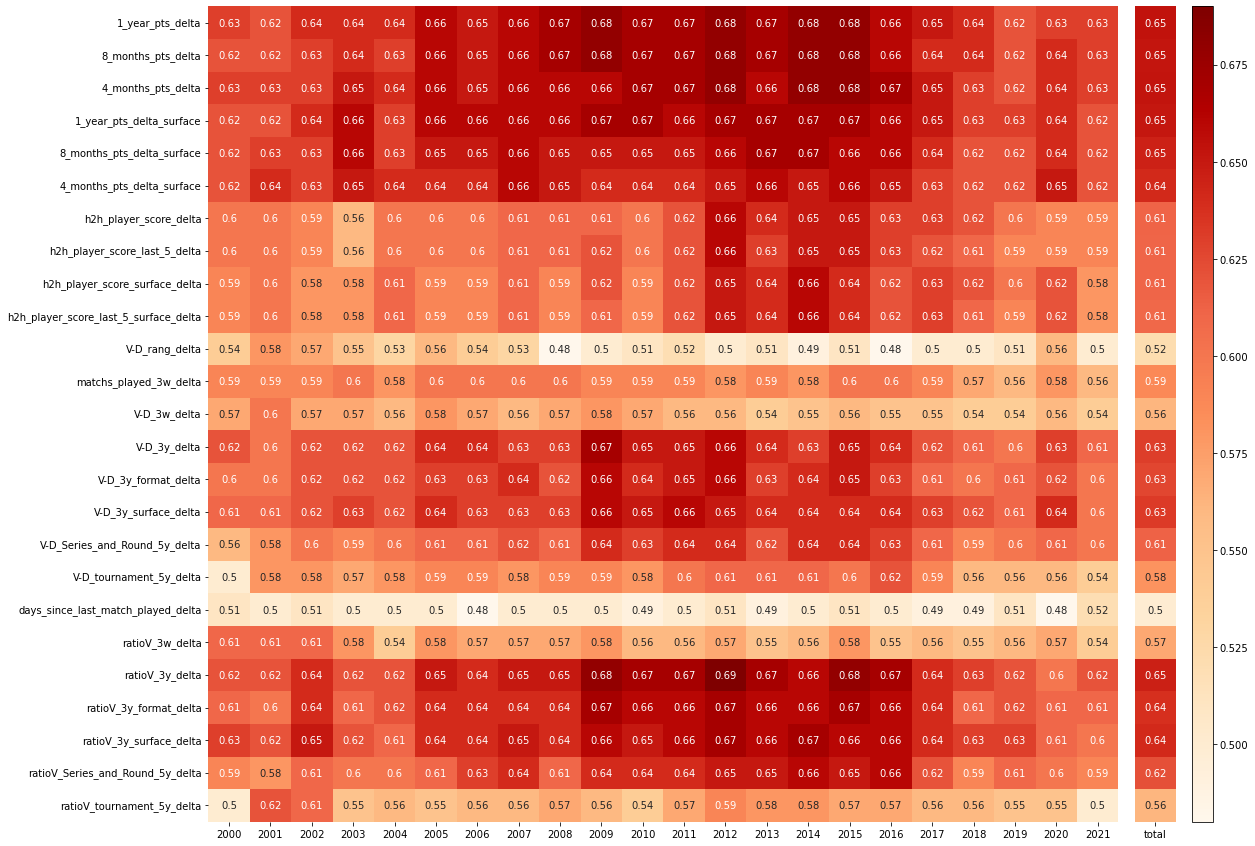

In [11]:
df_corr.replace(to_replace = [np.NaN], value = [0.5], inplace = True) ####

df_moy_corr = pd.DataFrame(df_corr.mean(axis = 1)).rename({0:'total'}, axis =1)

vmin = min(df_corr.values.min(), df_moy_corr.values.min())
vmax = max(df_corr.values.max(), df_moy_corr.values.max())

fig, axs = plt.subplots(ncols=3, gridspec_kw=dict(width_ratios=[22,1,0.5], wspace=0.05))
fig.set_size_inches(18, 15)


sns.heatmap(df_corr, annot=True, cmap="OrRd", cbar=False, ax=axs[0], vmin=vmin, vmax=vmax), #linewidths=0.01, linecolor='white')
sns.heatmap(df_moy_corr, annot=True, cmap="OrRd", yticklabels=False, cbar=False, ax=axs[1], vmin=vmin, vmax=vmax)#, linewidths=0.01, linecolor='white')

fig.colorbar(axs[1].collections[0], cax=axs[2])

plt.savefig('corr_taux_reussite.png')
plt.show()

Affichage de la heatmap du taux de valeurs prédictibles

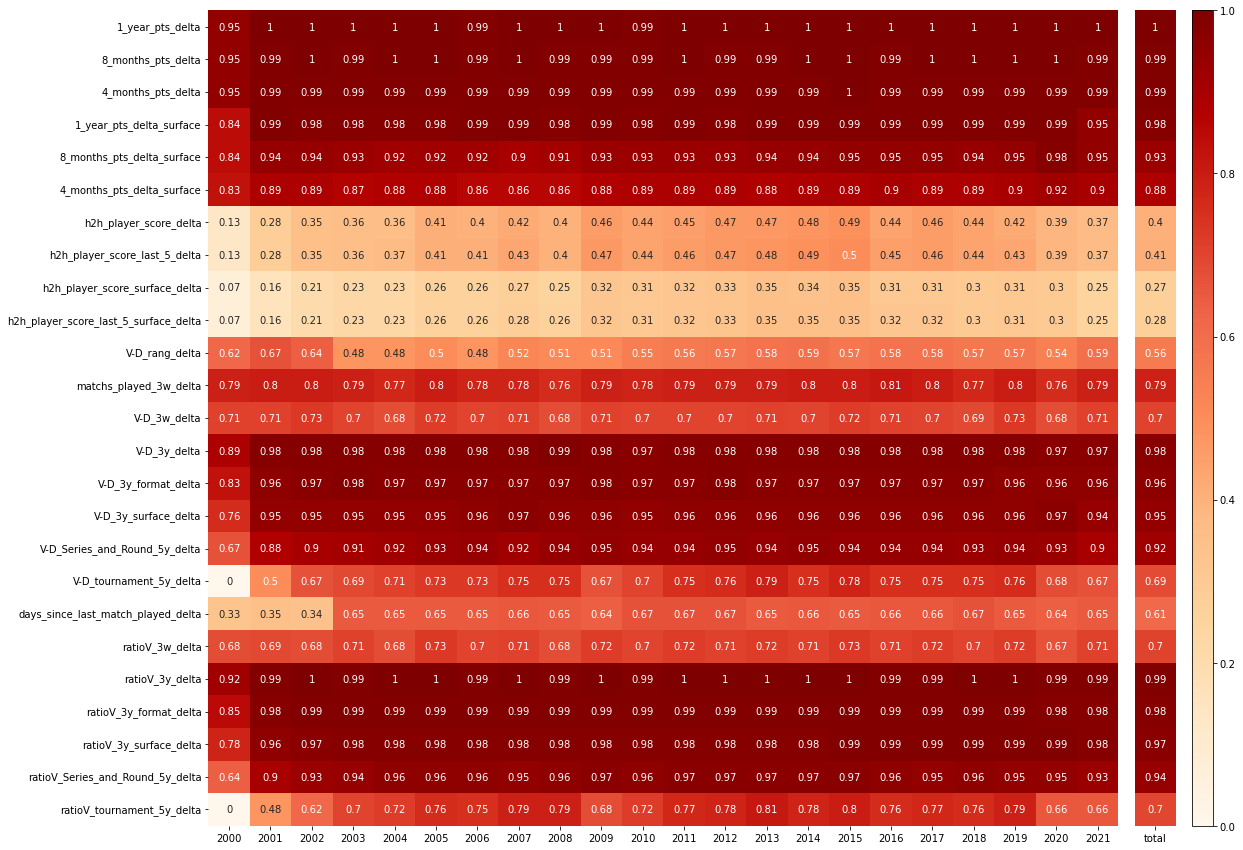

In [12]:
df_moy_indeter = pd.DataFrame(df_indeter.mean(axis = 1)).rename({0:'total'}, axis =1)

vmin = min(df_indeter.values.min(), df_moy_indeter.values.min())
vmax = max(df_indeter.values.max(), df_moy_indeter.values.max())

fig, axs = plt.subplots(ncols=3, gridspec_kw=dict(width_ratios=[22,1,0.5], wspace=0.05))
fig.set_size_inches(18, 15)


sns.heatmap(df_indeter, annot=True, cmap="OrRd", cbar=False, ax=axs[0], vmin=vmin, vmax=vmax), #linewidths=0.01, linecolor='white')
sns.heatmap(df_moy_indeter, annot=True, cmap="OrRd", yticklabels=False, cbar=False, ax=axs[1], vmin=vmin, vmax=vmax)#, linewidths=0.01, linecolor='white')

fig.colorbar(axs[1].collections[0], cax=axs[2])

plt.savefig('taux_var_indeter.png')
plt.show()

# Partie modèle de prédiction

Découpage du dataset de début 2005 à 2020 juste avant la période de la pandémie du covid.
On gardera 80% du dataset pour le train et 20% pour le test. Ce découpage s'effectue de manière chronologique.

In [13]:
start = 14518 #début année 2005
end = 55459 #début covid 2020

df = df.loc[start:end,:]

size_dataset = len(df)
proportion_train = 80

size_train = size_dataset*proportion_train//100

data = df.drop('target', axis = 1)
target = df['target']

X_train = data.loc[:start+size_train-1,:]
y_train = target.loc[:start+size_train-1]
 
X_test = data.loc[start+size_train:,:]
y_test = target.loc[start+size_train:]

On fit et normalise à partir d'un MinMax sur le X_train et ensuite on l'applique sur le X_test de telle sorte que celui-ci soit transformé avec l'échelle de référence de X_train

In [14]:
#scaler = preprocessing.StandardScaler()
scaler = preprocessing.MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_test = pd.DataFrame(scaler.transform(X_test))

In [15]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0.525541,0.538313,0.529321,0.522997,0.491194,0.527652,0.512821,0.5,0.514286,0.5,...,0.489796,0.139912,0.492212,0.201767,0.498403,0.171310,0.517857,0.142695,0.523077,0.663300
1,0.504357,0.512129,0.501689,0.511553,0.476885,0.514435,0.487179,0.4,0.485714,0.4,...,0.487755,0.090596,0.445483,0.077621,0.511182,0.096366,0.410714,0.070707,0.523077,0.141414
2,0.483924,0.496920,0.501996,0.486720,0.462025,0.497043,0.512821,0.5,0.514286,0.5,...,0.485714,0.084844,0.464174,0.077972,0.501597,0.082410,0.428571,0.055944,0.538462,0.090909
3,0.497296,0.517713,0.505987,0.506586,0.481288,0.514435,0.538462,0.6,0.514286,0.5,...,0.500000,0.098960,0.473520,0.091230,0.507987,0.092456,0.455357,0.077523,0.492308,0.005051
4,0.513522,0.530997,0.508443,0.492550,0.463952,0.503304,0.538462,0.6,0.514286,0.5,...,0.530612,0.121190,0.514019,0.107172,0.527157,0.076975,0.526786,0.101166,0.538462,0.030303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32748,0.610727,0.639392,0.626957,0.621464,0.605118,0.652174,0.692308,1.0,0.628571,0.9,...,0.608163,0.116195,0.563863,0.114002,0.607029,0.102675,0.580357,0.160839,0.723077,0.121651
32749,0.815805,0.893531,0.810869,0.743036,0.747661,0.860522,0.589744,0.8,0.542857,0.6,...,0.779592,0.147410,0.619938,0.161229,0.801917,0.143125,0.651786,0.580420,0.769231,0.129223
32750,0.460938,0.489988,0.495855,0.465990,0.465327,0.503652,0.538462,0.6,0.542857,0.6,...,0.467347,0.095480,0.454829,0.085006,0.476038,0.095182,0.410714,0.007692,0.430769,0.084175
32751,0.646034,0.666538,0.596254,0.657525,0.625206,0.617391,0.564103,0.7,0.571429,0.7,...,0.730612,0.205390,0.560748,0.204585,0.744409,0.179440,0.535714,0.652348,0.676923,0.131313


Test de plusieurs modèles de classification avec **GridSearchCV**

In [14]:
#model = ensemble.RandomForestClassifier()
#model = KNeighborsClassifier() 
#model = svm.SVC()
#model = DecisionTreeClassifier()

#parameters = {'max_features': ["sqrt", "log2", None ], 'min_samples_split': range(2, 40, 2)}
#parameters = {'n_neighbors': range(2,20), 'metric' : ['manhattan', 'minkowski']}
#parameters = {'C' : [0.1, 1, 10],'kernel' : ['rbf', 'linear', 'poly'], 'gamma' : [0.001, 0.1, 0.5]}
#parameters = {'criterion' : ['entropy', 'gini'], 'max_depth' : range(1,20)}

In [15]:
#grid = model_selection.GridSearchCV(estimator=model, param_grid=parameters)
#grid.fit(X_train, y_train)

#print("")
#print('Meilleurs paramètres :', grid.best_params_)
#print("")
#print("Score obtenu :", grid.score(X_test, y_test))

On implémente le modèle avec les meilleurs paramètres obtenus

In [24]:
rf = ensemble.RandomForestClassifier(n_jobs=-1, max_features = 'log2', min_samples_split = 38, random_state = 1)
#knn = KNeighborsClassifier(metric = 'manhattan', n_neighbors = 19) 
#svm = svm.SVC(C = 1, gamma = 0.5, kernel = 'rbf')
#dtc = DecisionTreeClassifier(criterion = 'gini', max_depth = 5)

À partir d'un SelectKBest on regarde quel est le nombre de variables et les variables optimales pour ce modèle.

In [19]:
clf = rf
all_scores = []
all_var = []

for k in range(1, len(X_train.columns)+1) :
    sel = SelectKBest(score_func = mutual_info_regression, k=k) 
    sel.fit(X_train, y_train)
    mask = sel.get_support()

    X_train_sel = X_train[X_train.columns[mask]]
    X_test_sel = X_test[X_test.columns[mask]]

    clf.fit(X_train_sel, y_train)
    score = clf.score(X_test_sel, y_test)
    all_scores.append(score)
    all_var.append(X_train_sel.columns)

best_score = (np.argmax(all_scores)+1, all_scores[np.argmax(all_scores)])

print("")
print('Le meilleur score obtenue est :',best_score[1],'pour',best_score[0],'features')
print("")
print('Les',best_score[0],'meilleures features retenues sont :', all_var[np.argmax(all_scores)])

filtre = all_var[np.argmax(all_scores)]

In [26]:
sel = SelectKBest(score_func = mutual_info_regression, k=22) 
sel.fit(X_train, y_train)
mask = sel.get_support()

X_train_sel = X_train[X_train.columns[mask]]
X_test_sel = X_test[X_test.columns[mask]]

rf.fit(X_train_sel, y_train)

y_pred = rf.predict(X_test_sel)

print("Le score de ce modèle est de :", rf.score(X_test_sel, y_test))

Le score de ce modèle est de : 0.6486750518988887


In [21]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.64      0.64      4082
           1       0.65      0.65      0.65      4107

    accuracy                           0.65      8189
   macro avg       0.65      0.64      0.64      8189
weighted avg       0.65      0.65      0.65      8189



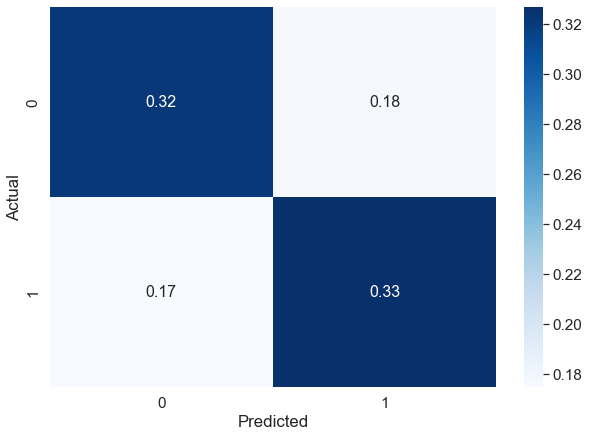

In [27]:
#cross = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
data = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))/len(y_test)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16});

Code qui permet de sélectionner toutes les observations mal prédites

In [28]:
df_all = df_all_years.loc[start:end,:]
df_test = df_all.loc[start+size_train:,:]

y_test_pred = pd.Series(y_pred+np.array(y_test))

df_test = df_test.reset_index().drop(['Unnamed: 0'], axis =1)

df_bad_pred = pd.concat([df_test, pd.DataFrame(y_test_pred)], axis=1)

df_bad_pred = df_bad_pred[df_bad_pred[0]==1]

In [29]:
df_series = pd.DataFrame(1-(df_bad_pred['Series'].value_counts()/df_test['Series'].value_counts()))

In [30]:
df_series = df_series.reset_index().rename(columns = {'Series':'Pourcentage', 'index' : 'Series'})

In [31]:
df_series

,Series,Pourcentage
0,ATP Final,0.555556
1,ATP250,0.609749
2,ATP500,0.661302
3,GS,0.734971
4,M1000,0.641387


Affiche le taux de réussite des prédictions par surface et par series

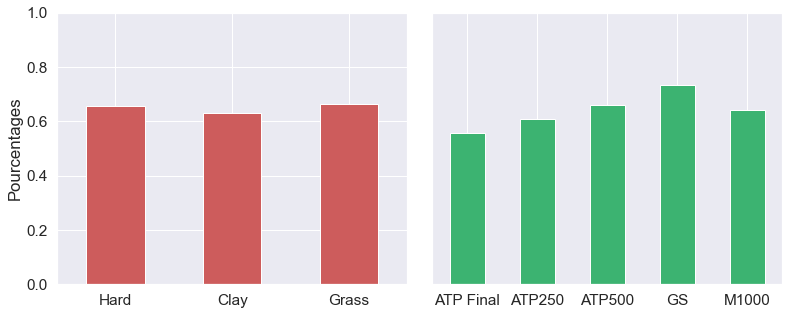

In [32]:
df_surface = pd.DataFrame(1-(df_bad_pred['Surface'].value_counts()/df_test['Surface'].value_counts()))
df_surface = df_surface.reset_index().rename(columns={'Surface':'values', 'index':' '})

df_series = pd.DataFrame(1-(df_bad_pred['Series'].value_counts()/df_test['Series'].value_counts()))
df_series = df_series.reset_index().rename(columns={'Series':'values', 'index':' '})

fig, axes = plt.subplots(figsize=(13,5),nrows=1, ncols=2)
plt.subplots_adjust(wspace=0.07)

ax1=plt.subplot(1,2,1)
ax2=plt.subplot(1,2,2)

df_surface.plot.bar(ax = ax1, x=' ', y='values', color = 'indianred', rot=0)
ax1.set_ylabel('Pourcentages')
ax1.legend().set_visible(False)
ax1.set_ylim([0,1])

df_series.plot.bar(ax = ax2, x=' ', y='values', color = 'mediumseagreen', rot=0)
ax2.set_ylabel('Pourcentages')
ax2.legend().set_visible(False)
ax2.yaxis.set_visible(False)
ax2.set_ylim([0,1])

plt.savefig('taux_reussite_surface_series.pdf')
plt.show()

In [36]:
df_bad_pred_M1000 = df_bad_pred[ df_bad_pred['Series'] == 'M1000']
df_test_M1000 = df_test[ df_test['Series'] == 'M1000']

df_round_M1000 = pd.DataFrame(1-(df_bad_pred_M1000['Round'].value_counts()/df_test_M1000['Round'].value_counts()))
df_round_M1000 = df_round_M1000.reset_index().rename(columns = {'Round':'Pourcentage', 'index' : 'Round'})

Affiche le taux de réussite des prédictions par tours de Grand Chelem et de Master 1000

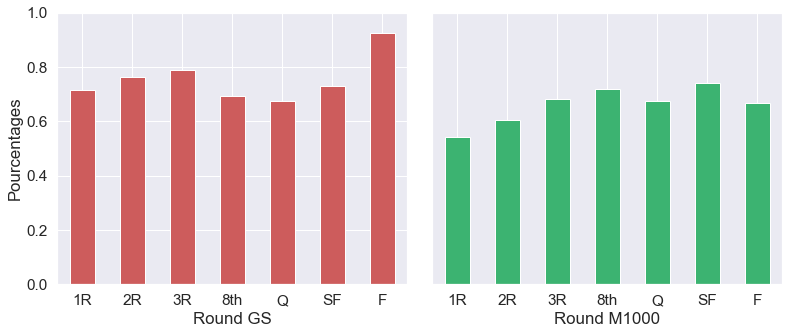

In [37]:
df_bad_pred_GS = df_bad_pred[ df_bad_pred['Series'] == 'GS']
df_test_GS = df_test[ df_test['Series'] == 'GS']

df_round_GS = pd.DataFrame(1-(df_bad_pred_GS['Round'].value_counts()/df_test_GS['Round'].value_counts()))
df_round_GS = df_round_GS.reset_index().rename(columns={'Round':'values', 'index':'Round GS'})

df_bad_pred_M1000 = df_bad_pred[ df_bad_pred['Series'] == 'M1000']
df_test_M1000 = df_test[ df_test['Series'] == 'M1000']

df_round_M1000 = pd.DataFrame(1-(df_bad_pred_M1000['Round'].value_counts()/df_test_M1000['Round'].value_counts()))
df_round_M1000 = df_round_M1000.reset_index().rename(columns={'Round':'values', 'index':'Round M1000'})
df_round_M1000 = df_round_M1000.set_index('Round M1000').transpose()[['1R','2R','3R','8th','Q','SF','F']].transpose().reset_index()

fig, axes = plt.subplots(figsize=(13,5),nrows=1, ncols=2)
plt.subplots_adjust(wspace=0.07)

ax1=plt.subplot(1,2,1)
ax2=plt.subplot(1,2,2)

df_round_GS.plot.bar(ax = ax1, x='Round GS', y='values', color = 'indianred', rot=0)
ax1.set_ylabel('Pourcentages')
ax1.legend().set_visible(False)
ax1.set_ylim([0,1])

df_round_M1000.plot.bar(ax = ax2, x='Round M1000', y='values', color = 'mediumseagreen', rot=0)
ax2.set_ylabel('Pourcentages')
ax2.legend().set_visible(False)
ax2.yaxis.set_visible(False)
ax2.set_ylim([0,1])

plt.savefig('taux_reussite_round_GS_M1000.pdf')
plt.show()

In [38]:
df_tournament = pd.DataFrame(1-(df_bad_pred['Tournament'].value_counts()/df_test['Tournament'].value_counts()))
df_tournament = df_tournament.reset_index().rename(columns={'Tournament':'Pourcentage', 'index':'Tournament'})
df_tournament_best = df_tournament.sort_values(by='Pourcentage', ascending = False).head(8)

In [39]:
df_tournament_best = df_tournament.sort_values(by='Pourcentage', ascending = False).head(8)

In [40]:
df_tournament_best

,Tournament,Pourcentage
52,Roland Garros,0.763780
6,Australian Open,0.754950
8,Basel Championship IH,0.741935
10,Beijing Championship,0.741935
60,St. Petersburg Championship IH,0.740741
70,Wimbledon,0.729659
0,Acapulco Championship OH,0.709677
24,Halle Championship,0.709677


Affiche le taux de réussite des prédictions par tournois

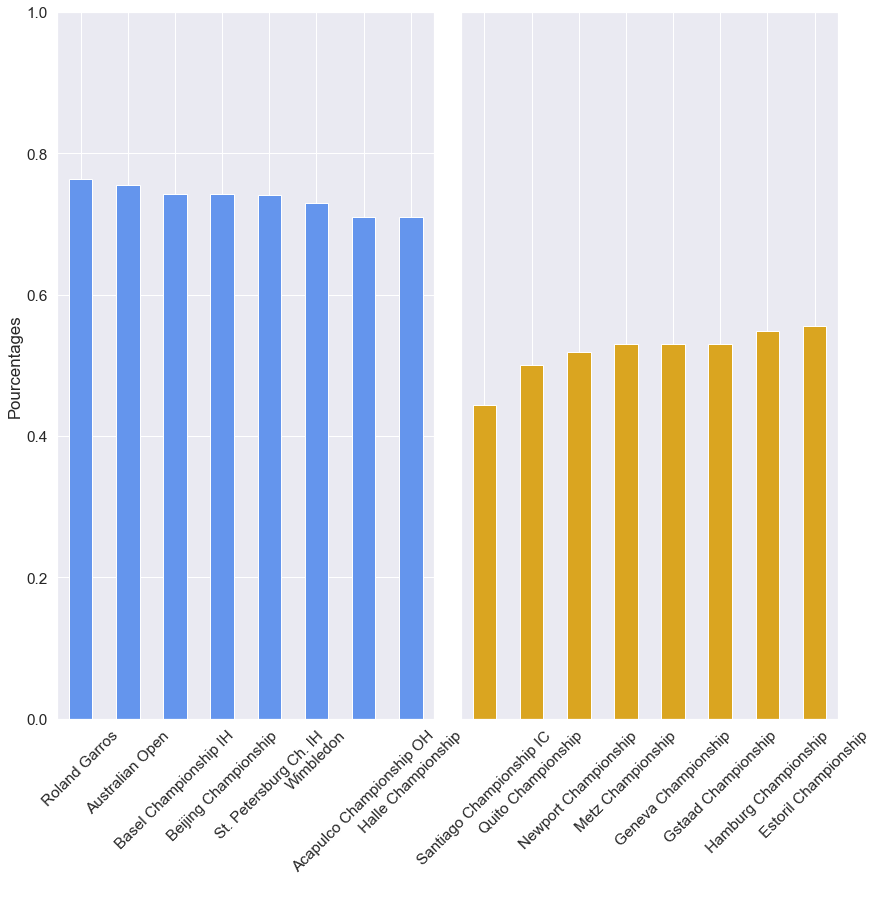

In [41]:
df_tournament = pd.DataFrame(1-(df_bad_pred['Tournament'].value_counts()/df_test['Tournament'].value_counts()))
df_tournament = df_tournament.reset_index().rename(columns={'Tournament':'values', 'index':' '})

df_tournament_best = df_tournament.sort_values(by='values', ascending = False).head(8)
df_tournament_best.replace(to_replace = ['St. Petersburg Championship IH'], value = ['St. Petersburg Ch. IH'],
                          inplace = True)
df_tournament_bad = df_tournament.sort_values(by='values', ascending = True).head(8)

fig, axes = plt.subplots(figsize=(14,13),nrows=1, ncols=2)
plt.subplots_adjust(wspace=0.07)

ax1=plt.subplot(1,2,1)
ax2=plt.subplot(1,2,2)

df_tournament_best.plot.bar(ax = ax1, x=' ', y='values', color = 'cornflowerblue', rot=45)
ax1.set_ylabel('Pourcentages')
ax1.legend().set_visible(False)
ax1.set_ylim([0,1])

df_tournament_bad.plot.bar(ax = ax2, x=' ', y='values', color = 'goldenrod', rot=45)
ax2.set_ylabel('Pourcentages')
ax2.legend().set_visible(False)
ax2.yaxis.set_visible(False)
ax2.set_ylim([0,1])

plt.savefig('taux_reussite_tournament.pdf')
plt.show()